# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


In [2]:
#catboost 모델 설치
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

In [4]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR,"train.csv"))
train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,NaN,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,NaN,NaN,...,14,NaN,NaN,197,NaN,NaN,1,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,NaN,NaN,...,1,NaN,NaN,27,NaN,NaN,1,NaN,NaN,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,NaN,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


## 데이터 전처리


In [5]:
# 모든 값이 결측치인 컬럼 제거
train_data = train_data.dropna(axis=1, how='all')

# 모든 값이 동일한 컬럼 제거
train_data = train_data.loc[:, (train_data != train_data.iloc[0]).any()]

train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,1000.0,12.5,90,100,280,90,16,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


In [6]:
# 수치형 변수에 OK가 들어가 있는 경우 -> 결측 값으로 대체한다
train_data.loc[:, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].replace('OK', np.nan)
train_data.loc[:, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].replace('OK', np.nan)
train_data.loc[:, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].replace('OK', np.nan)

train_data[['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam','HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']]

,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2
0,NaN,NaN,NaN
1,550.3,838.4,835.5
2,NaN,NaN,NaN
3,162.4,837.7,305
4,549,838.4,835.5
...,...,...,...
40501,550.3,838.4,835.5
40502,NaN,NaN,NaN
40503,NaN,NaN,NaN
40504,162.4,837.7,305


### 범주형 컬럼 전처리

In [7]:
# 중복 컬럼을 삭제
train_data = train_data.drop(['Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage1 Circle4 Distance Speed Collect Result_Dam'], axis=1)
train_data = train_data.drop(['Stage2 Circle3 Distance Speed Collect Result_Dam', 'Stage2 Circle4 Distance Speed Collect Result_Dam'], axis=1)
train_data = train_data.drop(['Stage3 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam'], axis=1)

In [8]:
# 중복 컬럼을 삭제
train_data = train_data.drop(['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2', 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'], axis=1)

In [9]:
# 중복 컬럼을 삭제
train_data = train_data.drop(['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'], axis=1)
train_data = train_data.drop(['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'], axis=1)

In [10]:
train_data.head()

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal


### 수치형 컬럼 전처리

In [11]:
# 새로운 이진 범주형 컬럼을 추가
def categorize_row(row):
    if (row['CURE END POSITION X Collect Result_Dam'] == 240.0):
        return 0
    else:
        return 1

train_data['CURE POSITION Collect Result_Dam'] = train_data.apply(categorize_row, axis=1)

# 기존 컬럼 드롭
train_data = train_data.drop(columns=['CURE END POSITION X Collect Result_Dam',
                                      'CURE END POSITION Z Collect Result_Dam',
                                      'CURE END POSITION Θ Collect Result_Dam',
                                      'CURE START POSITION X Collect Result_Dam',
                                      'CURE START POSITION Θ Collect Result_Dam'])

In [12]:
# 새로운 이진 범주형 컬럼을 추가
def categorize_row(row):
    if (row['HEAD Standby Position Y Collect Result_Dam'] == 66):
        return 0
    else:
        return 1

train_data['HEAD Standby Position Collect Result_Dam'] = train_data.apply(categorize_row, axis=1)

# 기존 컬럼 드롭
train_data = train_data.drop(columns=['HEAD Standby Position X Collect Result_Dam',
                                      'HEAD Standby Position Y Collect Result_Dam',
                                      'HEAD Standby Position Z Collect Result_Dam'])

In [13]:
# 기존 컬럼 드롭
train_data = train_data.drop(columns=['HEAD Standby Position X Collect Result_Fill1',
                                      'HEAD Standby Position Y Collect Result_Fill1',
                                      'HEAD Standby Position Z Collect Result_Fill1',
                                      'HEAD Standby Position X Collect Result_Fill2',
                                      'HEAD Standby Position Y Collect Result_Fill2',
                                      'HEAD Standby Position Z Collect Result_Fill2'])

In [14]:
# 기존 컬럼 드롭
train_data = train_data.drop(columns=['Head Clean Position X Collect Result_Dam',
                                      'Head Clean Position Y Collect Result_Dam',
                                      'Head Clean Position Z Collect Result_Dam'])

# 기존 컬럼 드롭
train_data = train_data.drop(columns=['Head Clean Position X Collect Result_Fill1',
                                      'Head Clean Position Y Collect Result_Fill1',
                                      'Head Clean Position Z Collect Result_Fill1',
                                      'Head Clean Position X Collect Result_Fill2',
                                      'Head Clean Position Y Collect Result_Fill2',
                                      'Head Clean Position Z Collect Result_Fill2'])

In [15]:
# 새로운 이진 범주형 컬럼을 추가
def categorize_row(row):
    if (row['Head Purge Position X Collect Result_Fill1'] == 92.2):
        return 0
    else:
        return 1

train_data['Head Purge Position Collect Result_Fill'] = train_data.apply(categorize_row, axis=1)

# 기존 컬럼 드롭
train_data = train_data.drop(columns=['Head Purge Position X Collect Result_Fill1',
                                      'Head Purge Position Y Collect Result_Fill1',
                                      'Head Purge Position X Collect Result_Fill2',
                                      'Head Purge Position Y Collect Result_Fill2',
                                      'Head Purge Position Z Collect Result_Fill2'])

In [16]:
# 4개의 범주로 나누는 함수 정의
def categorize_row(row):
    if (row['Head Zero Position X Collect Result_Dam'] == 130.85) and \
       (row['Head Zero Position Y Collect Result_Dam'] == 505.0) and \
       (row['Head Zero Position Z Collect Result_Dam'] == 300.0):
        return 0
    elif (row['Head Zero Position X Collect Result_Dam'] == 505.00) and \
         (row['Head Zero Position Y Collect Result_Dam'] == 300.0) and \
         (row['Head Zero Position Z Collect Result_Dam'] == 265.0):
        return 1
    elif (row['Head Zero Position X Collect Result_Dam'] == 505.00) and \
         (row['Head Zero Position Y Collect Result_Dam'] == 303.5) and \
         (row['Head Zero Position Z Collect Result_Dam'] == 265.0):
    ㄹ    return 2
    elif (row['Head Zero Position X Collect Result_Dam'] == 130.85) and \
         (row['Head Zero Position Y Collect Result_Dam'] == 505.0) and \
         (row['Head Zero Position Z Collect Result_Dam'] == 303.5):
        return 3

# 새로운 이진 범주형 컬럼 추가
train_data['Head Zero Position Collect Result_Dam'] = train_data.apply(categorize_row, axis=1)

# 기존 컬럼 드롭
train_data = train_data.drop(columns=['Head Zero Position X Collect Result_Dam',
                                      'Head Zero Position Y Collect Result_Dam',
                                      'Head Zero Position Z Collect Result_Dam'])

In [17]:
# 기존 컬럼 드롭 - 추가

# Stage1/2/3 Line1 Distance Speed Collect Result_Dam = Stage1/2/3 Line3 Distance Speed Collect Result_Dam

train_data = train_data.drop(columns=['Stage1 Line3 Distance Speed Collect Result_Dam',
                                      'Stage2 Line3 Distance Speed Collect Result_Dam',
                                      'Stage3 Line3 Distance Speed Collect Result_Dam'])

In [18]:
# 기존 컬럼 드롭 - 추가

# DISCHARGED TIME OF RESIN(Stage1/2/3)  =  Dispense Volume(Stage1/2/3) Collect

train_data = train_data.drop(columns=['Dispense Volume(Stage1) Collect Result_Fill1',
                                      'Dispense Volume(Stage2) Collect Result_Fill1',
                                      'Dispense Volume(Stage3) Collect Result_Fill1'])

In [19]:
train_data.head()

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,CURE POSITION Collect Result_Dam,HEAD Standby Position Collect Result_Dam,Head Purge Position Collect Result_Fill,Head Zero Position Collect Result_Dam
0,Dam dispenser #1,AJX75334505,4F1XA938-1,100,16,14.9,8.4,14.7,1.04,0.58,...,114.612,19.9,7,127,1,Normal,0,1,0,0
1,Dam dispenser #1,AJX75334505,3KPM0016-2,70,10,21.3,4.9,21.3,1.49,0.34,...,19.600,7.0,185,1,0,Normal,0,0,1,1
2,Dam dispenser #2,AJX75334501,4E1X9167-1,85,16,14.7,8.5,14.7,1.61,0.93,...,114.612,19.8,10,73,1,Normal,1,1,0,0
3,Dam dispenser #2,AJX75334501,3K1X0057-1,70,10,21.3,8.4,21.3,1.49,0.58,...,19.900,12.0,268,1,0,Normal,1,0,1,1
4,Dam dispenser #1,AJX75334501,3HPM0007-1,70,10,9.7,4.9,9.6,0.67,0.34,...,19.700,8.0,121,1,0,Normal,0,0,1,1


## K-MEANS 

In [56]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [57]:
important_features = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

df_important = train_data[important_features]

/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elicer/.local/lib/python3.

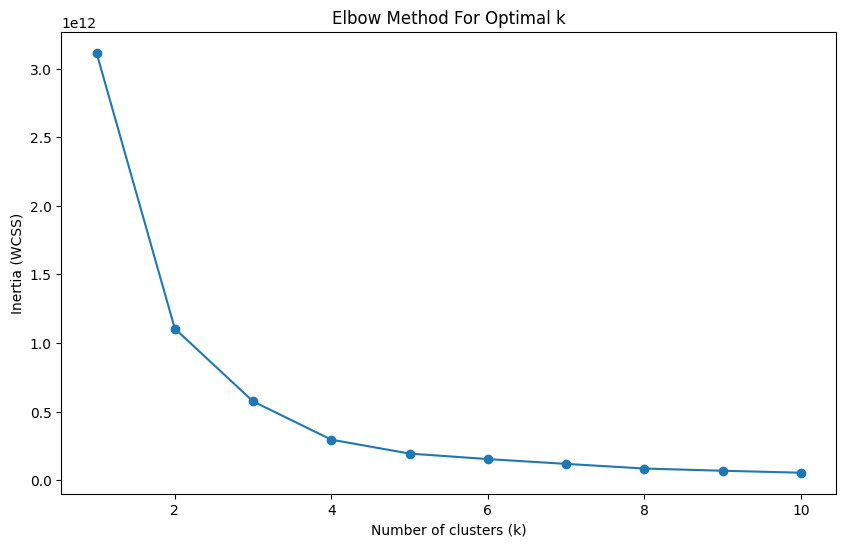

In [58]:
#엘보우 메소드를 통해 최적의 클러스터 수 찾기
inertia = []  # 각 클러스터 수에 따른 inertia 값을 저장

# 클러스터 수를 1부터 10까지 변화시키면서 KMeans를 적용
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_important)
    inertia.append(kmeans.inertia_)

# 4단계: 엘보우 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.show()

In [59]:
# 클러스터링 전에 변수들을 표준화
scaler = StandardScaler()
df_important_scaled = scaler.fit_transform(df_important)

In [60]:
# k-means 클러스터링 적용
kmeans = KMeans(n_clusters=3, random_state=42) 
train_data['Cluster_Label'] = kmeans.fit_predict(df_important_scaled)

/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [61]:
train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,CURE POSITION Collect Result_Dam,HEAD Standby Position Collect Result_Dam,Head Purge Position Collect Result_Fill,Head Zero Position Collect Result_Dam,Cluster_Label
0,Dam dispenser #1,AJX75334505,4F1XA938-1,100,16,14.9,8.4,14.7,1.04,0.58,...,19.9,7,127,1,Normal,0,1,0,0,1
1,Dam dispenser #1,AJX75334505,3KPM0016-2,70,10,21.3,4.9,21.3,1.49,0.34,...,7.0,185,1,0,Normal,0,0,1,1,0
2,Dam dispenser #2,AJX75334501,4E1X9167-1,85,16,14.7,8.5,14.7,1.61,0.93,...,19.8,10,73,1,Normal,1,1,0,0,2
3,Dam dispenser #2,AJX75334501,3K1X0057-1,70,10,21.3,8.4,21.3,1.49,0.58,...,12.0,268,1,0,Normal,1,0,1,1,0
4,Dam dispenser #1,AJX75334501,3HPM0007-1,70,10,9.7,4.9,9.6,0.67,0.34,...,8.0,121,1,0,Normal,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,70,10,17.0,5.0,17.0,1.19,0.35,...,1.0,318,1,0,Normal,0,0,1,1,0
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,100,16,14.9,8.5,14.7,1.04,0.59,...,20.5,14,197,1,Normal,1,1,0,0,2
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,100,16,14.2,8.2,14.3,0.99,0.57,...,19.7,1,27,1,Normal,0,1,0,0,1
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,70,10,9.7,4.9,9.7,0.67,0.34,...,13.0,117,1,0,Normal,1,0,1,1,0


### 결측치 제거

In [62]:
# 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam' 컬럼에서 NaN 값을 'nan' 문자열로 대체
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].fillna('nan')

In [63]:
# 1. 결측치 제거 (필요)
# 수치형 데이터에 대해 결측치-> 평균값으로 대체, 비수치형 데이터 결측치 -> 최빈값으로 대체
num_columns = train_data.select_dtypes(exclude=['object']).columns
categorical_columns = train_data.select_dtypes(include=['object']).columns


train_data[num_columns] = train_data[num_columns].fillna(train_data[num_columns].mean())
for col in categorical_columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

In [64]:
# 라이브러리 load

from sklearn.model_selection import StratifiedKFold, GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, f1_score

## 언더샘플링

In [65]:
# 원본 데이터에서 Normal과 AbNormal 데이터를 분리합니다.
df_normal = train_data[train_data["target"] == "Normal"]
df_abnormal = train_data[train_data["target"] == "AbNormal"]

num_abnormal = len(df_abnormal)

# 중복을 최소화하기 위해 선택된 인덱스를 저장할 집합
selected_indices = set()

# 여러 데이터셋 생성
datasets = []
seed_values = [110, 42, 333, 532, 806]  # 사용할 시드 값 목록, 필요한 만큼 시드 값을 추가할 수 있습니다.

for seed in seed_values:
    # 남은 데이터에서 샘플링
    available_samples = df_normal.loc[~df_normal.index.isin(selected_indices)]
    sampled = available_samples.sample(n=num_abnormal, replace=False, random_state=seed)

    # 샘플링된 인덱스 추가
    selected_indices.update(sampled.index)

    # 샘플링된 Normal 데이터와 모든 AbNormal 데이터를 합칩니다.
    df_concat = pd.concat([sampled, df_abnormal], axis=0).reset_index(drop=True)
    datasets.append(df_concat)

In [66]:
# normal_ratio = 1.0  # 1.0 means 1:1 ratio

# df_normal = train_data[train_data["target"] == "Normal"]
# df_abnormal = train_data[train_data["target"] == "AbNormal"]

# num_normal = len(df_normal)
# num_abnormal = len(df_abnormal)
# print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

# df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
# df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
# df_concat.value_counts("target")

In [67]:
# normal_ratio = 1.0  # 1.0 means 1:1 ratio

# df_normal = train_data[train_data["target"] == "Normal"]
# df_abnormal = train_data[train_data["target"] == "AbNormal"]

# num_normal = len(df_normal)
# num_abnormal = len(df_abnormal)
# print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

# df_normal2 = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=42)
# df_concat2 = pd.concat([df_normal2, df_abnormal], axis=0).reset_index(drop=True)
# df_concat2.value_counts("target")

In [68]:
# normal_ratio = 1.0  # 1.0 means 1:1 ratio

# df_normal = train_data[train_data["target"] == "Normal"]
# df_abnormal = train_data[train_data["target"] == "AbNormal"]

# num_normal = len(df_normal)
# num_abnormal = len(df_abnormal)
# print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

# df_normal3 = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=333)
# df_concat3 = pd.concat([df_normal3, df_abnormal], axis=0).reset_index(drop=True)
# df_concat3.value_counts("target")

## [ML1] 파라미터 지정

In [69]:
is_holdout = False
iterations =1000
patience = 150    # 조기 종료 조건을 150으로 설정

# Train/Val 데이터를 5-fold로 나누기
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 데이터 불균형을 고려하여 StratifiedKFold 사용

# 각 fold에 대한 예측값을 저장할 리스트
ensemble_preds = []

In [70]:
# 타겟 값의 True와 False의 비율에 따라 scale_pos_weight 설정
train_data['target'].value_counts()

scale_pos_weight = 38156/2350
scale_pos_weight

16.23659574468085

In [71]:
# 범주형 변수 지정
cat_features = ['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
       'Chamber Temp. Judge Value_AutoClave', 'Equipment_Fill1',
       'Equipment_Fill2','CURE POSITION Collect Result_Dam', 'HEAD Standby Position Collect Result_Dam',
        'Head Purge Position Collect Result_Fill', 'Head Zero Position Collect Result_Dam']

## [ML2] 모델 학습

In [72]:
from catboost import Pool,CatBoostClassifier

In [73]:
# CatBoost Model 학습
best_models = []

models = []
for train_index, val_index in kf.split(datasets[0].drop("target", axis=1), datasets[0]["target"]):
    print("="*50)

    # Train/Val 데이터 분할
    x_train_fold, x_val_fold = datasets[0].drop("target", axis=1).iloc[train_index], datasets[0].drop("target", axis=1).iloc[val_index]
    y_train_fold, y_val_fold = datasets[0]["target"].iloc[train_index], datasets[0]["target"].iloc[val_index]


    # 모델 학습
    model = CatBoostClassifier(iterations=iterations,random_state=42, eval_metric="F1", cat_features=cat_features, one_hot_max_size=4)
    model.fit(x_train_fold, y_train_fold,
            eval_set=[(x_val_fold, y_val_fold)],
            early_stopping_rounds=patience ,
            verbose = 100
        )

    fold_pred = model.predict(x_val_fold)

    # fold별 예측값 저장
    ensemble_preds.append(fold_pred)

    # 학습한 모델 저장
    best_models.append(model)

    if is_holdout:
        break

Learning rate set to 0.043952
0:	learn: 0.6009726	test: 0.5830785	best: 0.5830785 (0)	total: 14.3ms	remaining: 14.3s
100:	learn: 0.6693248	test: 0.6068376	best: 0.6158868 (31)	total: 762ms	remaining: 6.78s
200:	learn: 0.7020494	test: 0.6198953	best: 0.6219895 (195)	total: 1.48s	remaining: 5.88s
300:	learn: 0.7391881	test: 0.6277372	best: 0.6277372 (300)	total: 2.2s	remaining: 5.11s
400:	learn: 0.7793923	test: 0.6252588	best: 0.6307054 (327)	total: 2.91s	remaining: 4.34s
500:	learn: 0.8139535	test: 0.6237006	best: 0.6335404 (467)	total: 3.46s	remaining: 3.45s
600:	learn: 0.8374306	test: 0.6291667	best: 0.6335404 (467)	total: 3.93s	remaining: 2.61s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6335403727
bestIteration = 467

Shrink model to first 468 iterations.
Learning rate set to 0.043952
0:	learn: 0.5715865	test: 0.5363128	best: 0.5363128 (0)	total: 5.07ms	remaining: 5.07s
100:	learn: 0.6666667	test: 0.6425532	best: 0.6446105 (95)	total: 466ms	remaining: 4.15s


In [74]:
# CatBoost Model2 학습

for train_index, val_index in kf.split(datasets[1].drop("target", axis=1), datasets[1]["target"]):
    print("="*50)

    # Train/Val 데이터 분할
    x_train_fold, x_val_fold = datasets[1].drop("target", axis=1).iloc[train_index], datasets[1].drop("target", axis=1).iloc[val_index]
    y_train_fold, y_val_fold = datasets[1]["target"].iloc[train_index], datasets[1]["target"].iloc[val_index]


    # 모델 학습
    model = CatBoostClassifier(iterations=iterations,random_state=42, eval_metric="F1", cat_features=cat_features, one_hot_max_size=4)
    model.fit(x_train_fold, y_train_fold,
            eval_set=[(x_val_fold, y_val_fold)],
            early_stopping_rounds=patience ,
            verbose = 100
        )

    fold_pred = model.predict(x_val_fold)

    # fold별 예측값 저장
    ensemble_preds.append(fold_pred)

    # 학습한 모델 저장
    best_models.append(model)

    if is_holdout:
        break

Learning rate set to 0.043952
0:	learn: 0.5662749	test: 0.5665962	best: 0.5665962 (0)	total: 8.71ms	remaining: 8.7s
100:	learn: 0.6694517	test: 0.6453608	best: 0.6536885 (24)	total: 489ms	remaining: 4.35s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6536885246
bestIteration = 24

Shrink model to first 25 iterations.
Learning rate set to 0.043952
0:	learn: 0.6283270	test: 0.6314797	best: 0.6314797 (0)	total: 5.1ms	remaining: 5.09s
100:	learn: 0.6661430	test: 0.6295908	best: 0.6416667 (14)	total: 470ms	remaining: 4.18s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6416666667
bestIteration = 14

Shrink model to first 15 iterations.
Learning rate set to 0.043952
0:	learn: 0.5773253	test: 0.5682074	best: 0.5682074 (0)	total: 5.11ms	remaining: 5.1s
100:	learn: 0.6757039	test: 0.6404959	best: 0.6453608 (71)	total: 467ms	remaining: 4.16s
200:	learn: 0.7133924	test: 0.6328852	best: 0.6453608 (71)	total: 932ms	remaining: 3.7s
Stopped by overfitting 

In [75]:
# CatBoost Model3 학습

for train_index, val_index in kf.split(datasets[2].drop("target", axis=1), datasets[2]["target"]):
    print("="*50)

    # Train/Val 데이터 분할
    x_train_fold, x_val_fold = datasets[2].drop("target", axis=1).iloc[train_index], datasets[2].drop("target", axis=1).iloc[val_index]
    y_train_fold, y_val_fold = datasets[2]["target"].iloc[train_index], datasets[2]["target"].iloc[val_index]


    # 모델 학습
    model = CatBoostClassifier(iterations=iterations,random_state=42, eval_metric="F1", cat_features=cat_features, one_hot_max_size=4)
    model.fit(x_train_fold, y_train_fold,
            eval_set=[(x_val_fold, y_val_fold)],
            early_stopping_rounds=patience ,
            verbose = 100
        )

    fold_pred = model.predict(x_val_fold)

    # fold별 예측값 저장
    ensemble_preds.append(fold_pred)

    # 학습한 모델 저장
    best_models.append(model)

    if is_holdout:
        break

Learning rate set to 0.043952
0:	learn: 0.5788210	test: 0.5556734	best: 0.5556734 (0)	total: 5.05ms	remaining: 5.05s
100:	learn: 0.6868118	test: 0.6269592	best: 0.6337880 (61)	total: 475ms	remaining: 4.23s
200:	learn: 0.7145791	test: 0.6390041	best: 0.6410788 (192)	total: 936ms	remaining: 3.72s
300:	learn: 0.7514869	test: 0.6407369	best: 0.6438923 (223)	total: 1.39s	remaining: 3.23s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6438923395
bestIteration = 223

Shrink model to first 224 iterations.
Learning rate set to 0.043952
0:	learn: 0.5599329	test: 0.5107832	best: 0.5107832 (0)	total: 4.95ms	remaining: 4.95s
100:	learn: 0.6668410	test: 0.6440678	best: 0.6461211 (91)	total: 460ms	remaining: 4.09s
200:	learn: 0.7056063	test: 0.6406744	best: 0.6483633 (155)	total: 920ms	remaining: 3.66s
300:	learn: 0.7476538	test: 0.6464435	best: 0.6483633 (155)	total: 1.38s	remaining: 3.2s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6483632524
bestIterat

In [76]:
# CatBoost Model4 학습

for train_index, val_index in kf.split(datasets[3].drop("target", axis=1), datasets[3]["target"]):
    print("="*50)

    # Train/Val 데이터 분할
    x_train_fold, x_val_fold = datasets[3].drop("target", axis=1).iloc[train_index], datasets[3].drop("target", axis=1).iloc[val_index]
    y_train_fold, y_val_fold = datasets[3]["target"].iloc[train_index], datasets[3]["target"].iloc[val_index]


    # 모델 학습
    model = CatBoostClassifier(iterations=iterations,random_state=42, eval_metric="F1", cat_features=cat_features, one_hot_max_size=4)
    model.fit(x_train_fold, y_train_fold,
            eval_set=[(x_val_fold, y_val_fold)],
            early_stopping_rounds=patience ,
            verbose = 100
        )

    fold_pred = model.predict(x_val_fold)

    # fold별 예측값 저장
    ensemble_preds.append(fold_pred)

    # 학습한 모델 저장
    best_models.append(model)

    if is_holdout:
        break

Learning rate set to 0.043952
0:	learn: 0.5744212	test: 0.5560440	best: 0.5560440 (0)	total: 5.39ms	remaining: 5.39s
100:	learn: 0.6739869	test: 0.6023330	best: 0.6137339 (64)	total: 462ms	remaining: 4.11s
200:	learn: 0.7031867	test: 0.5981112	best: 0.6137339 (64)	total: 924ms	remaining: 3.67s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6137339056
bestIteration = 64

Shrink model to first 65 iterations.
Learning rate set to 0.043952
0:	learn: 0.6135338	test: 0.5880039	best: 0.5880039 (0)	total: 5.08ms	remaining: 5.07s
100:	learn: 0.6722251	test: 0.6272439	best: 0.6272439 (97)	total: 466ms	remaining: 4.15s
200:	learn: 0.7098121	test: 0.6304802	best: 0.6317992 (199)	total: 930ms	remaining: 3.7s
300:	learn: 0.7638636	test: 0.6253935	best: 0.6362694 (228)	total: 1.39s	remaining: 3.23s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6362694301
bestIteration = 228

Shrink model to first 229 iterations.
Learning rate set to 0.043952
0:	learn: 0.61

In [77]:
# CatBoost Model5 학습

for train_index, val_index in kf.split(datasets[4].drop("target", axis=1), datasets[4]["target"]):
    print("="*50)

    # Train/Val 데이터 분할
    x_train_fold, x_val_fold = datasets[4].drop("target", axis=1).iloc[train_index], datasets[4].drop("target", axis=1).iloc[val_index]
    y_train_fold, y_val_fold = datasets[4]["target"].iloc[train_index], datasets[4]["target"].iloc[val_index]


    # 모델 학습
    model = CatBoostClassifier(iterations=iterations,random_state=42, eval_metric="F1", cat_features=cat_features, one_hot_max_size=4)
    model.fit(x_train_fold, y_train_fold,
            eval_set=[(x_val_fold, y_val_fold)],
            early_stopping_rounds=patience ,
            verbose = 100
        )

    fold_pred = model.predict(x_val_fold)

    # fold별 예측값 저장
    ensemble_preds.append(fold_pred)

    # 학습한 모델 저장
    best_models.append(model)

    if is_holdout:
        break

Learning rate set to 0.043952
0:	learn: 0.6247246	test: 0.6184971	best: 0.6184971 (0)	total: 5.14ms	remaining: 5.13s
100:	learn: 0.6805770	test: 0.6226804	best: 0.6310584 (4)	total: 463ms	remaining: 4.12s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6310583581
bestIteration = 4

Shrink model to first 5 iterations.
Learning rate set to 0.043952
0:	learn: 0.6178981	test: 0.6253687	best: 0.6253687 (0)	total: 5.45ms	remaining: 5.45s
100:	learn: 0.6635368	test: 0.6243272	best: 0.6486486 (2)	total: 469ms	remaining: 4.17s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6486486486
bestIteration = 2

Shrink model to first 3 iterations.
Learning rate set to 0.043952
0:	learn: 0.5911203	test: 0.6016771	best: 0.6016771 (0)	total: 6.19ms	remaining: 6.18s
100:	learn: 0.6694473	test: 0.6352459	best: 0.6352459 (100)	total: 469ms	remaining: 4.17s
200:	learn: 0.7019557	test: 0.6327569	best: 0.6386037 (103)	total: 938ms	remaining: 3.73s
300:	learn: 0.7512347	t

In [78]:
# 각 flod 별 예측값 개수 조회
for idx, preds in enumerate(ensemble_preds):
    print(f"Fold {idx+1} 예측값 개수:", len(preds))

Fold 1 예측값 개수: 940
Fold 2 예측값 개수: 940
Fold 3 예측값 개수: 940
Fold 4 예측값 개수: 940
Fold 5 예측값 개수: 940
Fold 6 예측값 개수: 940
Fold 7 예측값 개수: 940
Fold 8 예측값 개수: 940
Fold 9 예측값 개수: 940
Fold 10 예측값 개수: 940
Fold 11 예측값 개수: 940
Fold 12 예측값 개수: 940
Fold 13 예측값 개수: 940
Fold 14 예측값 개수: 940
Fold 15 예측값 개수: 940
Fold 16 예측값 개수: 940
Fold 17 예측값 개수: 940
Fold 18 예측값 개수: 940
Fold 19 예측값 개수: 940
Fold 20 예측값 개수: 940
Fold 21 예측값 개수: 940
Fold 22 예측값 개수: 940
Fold 23 예측값 개수: 940
Fold 24 예측값 개수: 940
Fold 25 예측값 개수: 940


## 4. 제출하기


### 테스트 데이터 전처리

In [103]:
test_data = pd.read_csv(os.path.join(ROOT_DIR,"test.csv"))

In [104]:
# 새로운 이진 범주형 컬럼을 추가
def categorize_row(row):
    if (row['CURE END POSITION X Collect Result_Dam'] == 240.0):
        return 0
    else:
        return 1

test_data['CURE POSITION Collect Result_Dam'] = test_data.apply(categorize_row, axis=1)

# 기존 컬럼 드롭
test_data = test_data.drop(columns=['CURE END POSITION X Collect Result_Dam',
                                      'CURE END POSITION Z Collect Result_Dam',
                                      'CURE END POSITION Θ Collect Result_Dam',
                                      'CURE START POSITION X Collect Result_Dam',
                                      'CURE START POSITION Θ Collect Result_Dam'])

In [105]:
# 새로운 이진 범주형 컬럼을 추가
def categorize_row(row):
    if (row['HEAD Standby Position Y Collect Result_Dam'] == 66):
        return 0
    else:
        return 1

test_data['HEAD Standby Position Collect Result_Dam'] = test_data.apply(categorize_row, axis=1)

# 기존 컬럼 드롭
test_data = test_data.drop(columns=['HEAD Standby Position X Collect Result_Dam',
                                      'HEAD Standby Position Y Collect Result_Dam',
                                      'HEAD Standby Position Z Collect Result_Dam'])

# 기존 컬럼 드롭
test_data = test_data.drop(columns=['HEAD Standby Position X Collect Result_Fill1',
                                      'HEAD Standby Position Y Collect Result_Fill1',
                                      'HEAD Standby Position Z Collect Result_Fill1',
                                      'HEAD Standby Position X Collect Result_Fill2',
                                      'HEAD Standby Position Y Collect Result_Fill2',
                                      'HEAD Standby Position Z Collect Result_Fill2'])

In [106]:
# 기존 컬럼 드롭
test_data = test_data.drop(columns=['Head Clean Position X Collect Result_Dam',
                                      'Head Clean Position Y Collect Result_Dam',
                                      'Head Clean Position Z Collect Result_Dam'])

# 기존 컬럼 드롭
test_data = test_data.drop(columns=['Head Clean Position X Collect Result_Fill1',
                                      'Head Clean Position Y Collect Result_Fill1',
                                      'Head Clean Position Z Collect Result_Fill1',
                                      'Head Clean Position X Collect Result_Fill2',
                                      'Head Clean Position Y Collect Result_Fill2',
                                      'Head Clean Position Z Collect Result_Fill2'])

In [107]:
# 기존 컬럼 드롭 - 추가

# DISCHARGED TIME OF RESIN(Stage1/2/3)  =  Dispense Volume(Stage1/2/3) Collect

test_data = test_data.drop(columns=['Dispense Volume(Stage1) Collect Result_Fill1',
                                      'Dispense Volume(Stage2) Collect Result_Fill1',
                                      'Dispense Volume(Stage3) Collect Result_Fill1'])

In [108]:
# 기존 컬럼 드롭 - 추가

# Stage1/2/3 Line1 Distance Speed Collect Result_Dam = Stage1/2/3 Line3 Distance Speed Collect Result_Dam

test_data = test_data.drop(columns=['Stage1 Line3 Distance Speed Collect Result_Dam',
                                      'Stage2 Line3 Distance Speed Collect Result_Dam',
                                      'Stage3 Line3 Distance Speed Collect Result_Dam'])

In [109]:
# 새로운 이진 범주형 컬럼을 추가
def categorize_row(row):
    if (row['Head Purge Position X Collect Result_Fill1'] == 92.2):
        return 0
    else:
        return 1

test_data['Head Purge Position Collect Result_Fill'] = test_data.apply(categorize_row, axis=1)

           # 기존 컬럼 드롭
test_data = test_data.drop(columns=['Head Purge Position X Collect Result_Fill1',
                                      'Head Purge Position Y Collect Result_Fill1',
                                      'Head Purge Position X Collect Result_Fill2',
                                      'Head Purge Position Y Collect Result_Fill2',
                                      'Head Purge Position Z Collect Result_Fill2'])

In [110]:
# 4개의 범주로 나누는 함수 정의
def categorize_row(row):
    if (row['Head Zero Position X Collect Result_Dam'] == 130.85) and \
       (row['Head Zero Position Y Collect Result_Dam'] == 505.0) and \
       (row['Head Zero Position Z Collect Result_Dam'] == 300.0):
        return 0
    elif (row['Head Zero Position X Collect Result_Dam'] == 505.00) and \
         (row['Head Zero Position Y Collect Result_Dam'] == 300.0) and \
         (row['Head Zero Position Z Collect Result_Dam'] == 265.0):
        return 1
    elif (row['Head Zero Position X Collect Result_Dam'] == 505.00) and \
         (row['Head Zero Position Y Collect Result_Dam'] == 303.5) and \
         (row['Head Zero Position Z Collect Result_Dam'] == 265.0):
        return 2
    elif (row['Head Zero Position X Collect Result_Dam'] == 130.85) and \
         (row['Head Zero Position Y Collect Result_Dam'] == 505.0) and \
         (row['Head Zero Position Z Collect Result_Dam'] == 303.5):
        return 3

# 새로운 이진 범주형 컬럼 추가
test_data['Head Zero Position Collect Result_Dam'] = test_data.apply(categorize_row, axis=1)

# 기존 컬럼 드롭
test_data = test_data.drop(columns=['Head Zero Position X Collect Result_Dam',
                                      'Head Zero Position Y Collect Result_Dam',
                                      'Head Zero Position Z Collect Result_Dam'])

In [111]:
# 테스트 데이터의 동일한 수치형 변수 선택 및 표준화
test_important = test_data[important_features]
test_important_scaled = scaler.transform(test_important)  # 같은 scaler 사용

# 테스트 데이터에 대해 클러스터 레이블 예측
test_data['Cluster_Label'] = kmeans.predict(test_important_scaled)

In [112]:
train_columns = train_data.columns.tolist()  # 컬럼 이름을 리스트로 저장

# train 데이터에 있는 컬럼들만 남기고 나머지 컬럼을 제거
test_data = test_data[train_columns]  # train_columns에 있는 컬럼들만 선택

test_data.head()

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,CURE POSITION Collect Result_Dam,HEAD Standby Position Collect Result_Dam,Head Purge Position Collect Result_Fill,Head Zero Position Collect Result_Dam,Cluster_Label
0,Dam dispenser #2,AJX75334501,3J1XF767-1,70,10,17.0,4.9,17.0,1.19,0.34,...,13.0,195,1,0,NaN,1,0,1,1,0
1,Dam dispenser #2,AJX75334501,4B1XD472-2,70,16,14.2,8.3,14.2,0.99,0.58,...,19.8,14,256,1,NaN,1,1,0,0,2
2,Dam dispenser #1,AJX75334501,3H1XE355-1,70,10,9.7,4.9,9.7,0.67,0.34,...,1.0,98,1,0,NaN,0,0,1,1,0
3,Dam dispenser #2,AJX75334501,3L1XA128-1,70,10,21.3,10.6,21.3,1.49,0.74,...,20.0,14,0,1,NaN,1,1,0,0,2
4,Dam dispenser #1,AJX75334501,4A1XA639-1,70,16,13.2,7.5,13.2,0.92,0.52,...,19.8,1,215,1,NaN,0,1,0,0,1


In [113]:
# 수치형 변수에 OK가 들어가 있는 경우 -> 결측 값으로 대체한다
test_data.loc[:, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].replace('OK', np.nan)
test_data.loc[:, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].replace('OK', np.nan)
test_data.loc[:, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].replace('OK', np.nan)

test_data[['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam','HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']]

,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2
0,162.4,837.7,305
1,NaN,NaN,NaN
2,549.5,838.4,835.5
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
17356,NaN,NaN,NaN
17357,NaN,NaN,NaN
17358,NaN,NaN,NaN
17359,549,837.9,835.5


In [114]:
# 테스트 데이터셋 결측값 처리 (훈련 데이터와 동일한 방식으로 처리)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].fillna('nan')

num_columns = test_data.select_dtypes(exclude=['object']).columns
categorical_columns = test_data.select_dtypes(include=['object']).columns

test_data[num_columns] = test_data[num_columns].fillna(test_data[num_columns].mean())
for col in categorical_columns:
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

In [115]:
test_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,CURE POSITION Collect Result_Dam,HEAD Standby Position Collect Result_Dam,Head Purge Position Collect Result_Fill,Head Zero Position Collect Result_Dam,Cluster_Label
0,Dam dispenser #2,AJX75334501,3J1XF767-1,70,10,17.0,4.9,17.0,1.19,0.34,...,13.0,195,1,0,NaN,1,0,1,1,0
1,Dam dispenser #2,AJX75334501,4B1XD472-2,70,16,14.2,8.3,14.2,0.99,0.58,...,19.8,14,256,1,NaN,1,1,0,0,2
2,Dam dispenser #1,AJX75334501,3H1XE355-1,70,10,9.7,4.9,9.7,0.67,0.34,...,1.0,98,1,0,NaN,0,0,1,1,0
3,Dam dispenser #2,AJX75334501,3L1XA128-1,70,10,21.3,10.6,21.3,1.49,0.74,...,20.0,14,0,1,NaN,1,1,0,0,2
4,Dam dispenser #1,AJX75334501,4A1XA639-1,70,16,13.2,7.5,13.2,0.92,0.52,...,19.8,1,215,1,NaN,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,Dam dispenser #2,AJX75334501,3K1XB597-1,70,10,21.3,10.6,21.3,1.49,0.74,...,19.5,14,131,1,NaN,1,1,0,0,2
17357,Dam dispenser #2,AJX75334501,4A1XB974-1,70,16,13.2,7.6,13.2,0.92,0.53,...,19.8,12,279,1,NaN,1,1,0,0,2
17358,Dam dispenser #1,AJX75334501,3L1XA998-1,70,16,13.2,6.6,13.2,1.45,0.72,...,20.5,4,66,1,NaN,0,1,0,0,1
17359,Dam dispenser #1,AJX75334501,3F1XC376-1,70,10,9.7,3.9,9.7,0.67,0.27,...,1.0,117,1,0,NaN,0,0,1,2,0


In [116]:
# 예측에 필요한 데이터 분리
x_test = test_data.drop(["target"], axis=1)

### 테스트 데이터 예측

In [98]:
# Test 데이터 예측
test_preds = []
for model in best_models:
    test_pred = model.predict(x_test)
    test_preds.append(test_pred)

In [99]:
test_preds

[array(['AbNormal', 'Normal', 'AbNormal', ..., 'Normal', 'Normal',
        'Normal'], dtype=object),
 array(['AbNormal', 'Normal', 'AbNormal', ..., 'Normal', 'AbNormal',
        'Normal'], dtype=object),
 array(['AbNormal', 'Normal', 'AbNormal', ..., 'Normal', 'AbNormal',
        'Normal'], dtype=object),
 array(['AbNormal', 'Normal', 'AbNormal', ..., 'Normal', 'AbNormal',
        'Normal'], dtype=object),
 array(['AbNormal', 'Normal', 'AbNormal', ..., 'Normal', 'AbNormal',
        'Normal'], dtype=object),
 array(['Normal', 'Normal', 'AbNormal', ..., 'Normal', 'AbNormal',
        'Normal'], dtype=object),
 array(['AbNormal', 'Normal', 'AbNormal', ..., 'AbNormal', 'AbNormal',
        'Normal'], dtype=object),
 array(['AbNormal', 'Normal', 'AbNormal', ..., 'AbNormal', 'AbNormal',
        'Normal'], dtype=object),
 array(['AbNormal', 'Normal', 'AbNormal', ..., 'AbNormal', 'AbNormal',
        'Normal'], dtype=object),
 array(['AbNormal', 'Normal', 'AbNormal', ..., 'AbNormal', 'AbNormal',


In [100]:
# 앙상블을 통한 최종 예측 모델 중 10개 이상 모델이 True로 예측할 경우
final_test_preds1 = []

for i in range(len(test_preds[0])):
    combined_test_preds = [test_preds[j][i] == 'AbNormal' for j in range(len(test_preds))]
    num_ones = sum(combined_test_preds)  # AbNormal 분류된 모델의 개수를 계산
    if num_ones >= 17:  # 10개 이상의 모델이 AbNormal 분류했을 경우
        final_test_preds1.append('AbNormal')   # 최종 예측을 Treu로 예측
    else:
        final_test_preds1.append('Normal')  # 그 외의 경우에는 False로 예측

In [96]:
# # 각 시드별로 폴드 결과를 앙상블
# seed_level_preds = []
# for seed_idx in range(0, 25, 5):  # 0, 5, 10, 15, 20 (시작 인덱스로 5개 시드를 관리)
#     # 각 시드의 5개 폴드 결과 합치기
#     combined_preds = np.array([test_preds[seed_idx + i] for i in range(5)])

#     # 투표 기반 앙상블 (5개 중 3개 이상이 'AbNormal'이면 'AbNormal'로 결정)
#     votes = np.sum(combined_preds == 'AbNormal', axis=0)
#     seed_pred = np.where(votes >= 3, 'AbNormal', 'Normal')
#     seed_level_preds.append(seed_pred)

# # 최종 앙상블을 위한 결합
# final_votes = np.sum(np.array(seed_level_preds) == 'AbNormal', axis=0)
# final_test_preds = np.where(final_votes >= 3, 'AbNormal', 'Normal')

# final_test_preds2 = final_test_preds.tolist()

### 제출 파일 작성


In [101]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = final_test_preds1

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [102]:
# # 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
# df_sub = pd.read_csv("submission.csv")
# df_sub["target"] = final_test_preds2

# # 제출 파일 저장
# df_sub.to_csv("submission_ver2.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
